In [25]:
# import the differents useful libraries for the work to be done
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
import datetime
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE, RFECV
from xgboost import XGBRegressor

import boto3

from functions import calendar_features,calculate_all_indicators, calculate_all_indicators_optimised

In [26]:
# import the dataset saved during the eda part from local computer
path = "btc_completed_optimized.csv"
btc=pd.read_csv(path, index_col=0)

In [27]:
# import the dataset saved during the eda part from S3

def read_credentials(file_path):
    """_summary_
    a function to recover access id and acess key for aws
    Args:
        file_path (string): path where is located the txt files containing credentials
    Returns:
        a list containing credientials
    """
    credentials = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split('=')
            credentials[key] = value
    return credentials

# Specify the path to credentials file
credentials_path = "access.txt"

# Read credentials from the file
credentials = read_credentials(credentials_path)

# Access individual credentials
access_key = credentials["access_key"]
secret_key = credentials["secret_key"]

# create a "ressource" session
session = boto3.Session(aws_access_key_id=access_key, aws_secret_access_key=secret_key)
s3 = session.resource("s3")

# dowload the csv file from an existing S3 bucket
dataset = s3.Bucket("myfinal-project").download_file(Filename="rawdata_yfinance_BTC.csv", Key="mydata/rawdata_yfinance_BTC.csv")

In [28]:
# sort the dataset by decreasing order from the most recent date to the oldest one
btc = btc.sort_index(ascending=False)

In [29]:
# btc = btc.drop(["High","Low","Open"],axis=1)

In [30]:
# overview of the dataset
btc.head()

,Open,High,Low,Close,Volume,Williams_%R14,ROC_14,rsi_7,rsi_14,rsi_28,...,VIX_21,OBV_10,CMF_5,VPT_7,A/D Line_3,EOM_14,targetvalue_j1,targetvalue_j2,targetvalue_j3,target_night
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-26,39568.429688,39568.429688,38260.019531,38260.019531,24599017472,-65.715316,-0.133885,39.504465,49.670717,61.194827,...,38.046943,1.033984e+12,890406.478148,8.020379e+10,-9.412966e+13,1.276762,NaN,NaN,NaN,NaN
2023-12-25,39657.515625,39868.914062,38848.808594,39045.214844,17092267976,-46.407695,-3.987770,63.867001,41.336123,62.910443,...,41.797435,1.036978e+12,882229.679932,8.066817e+10,-9.409370e+13,-7.472949,38260.019531,NaN,NaN,39568.429688
2023-12-24,39916.292969,39919.464844,39316.949219,39667.652344,12250301745,-32.996577,-2.263830,61.753297,44.789569,64.130386,...,41.333021,1.039312e+12,845852.364394,8.090838e+10,-9.406142e+13,-6.694091,39045.214844,38260.019531,NaN,39657.515625
2023-12-23,39857.914062,40339.125000,39388.527344,39903.324219,19071527621,-31.576800,-2.663987,68.001263,43.926169,65.108435,...,41.516936,1.042264e+12,761488.992765,8.098627e+10,-9.402694e+13,-5.612421,39667.652344,39045.214844,38260.019531,39916.292969
2023-12-22,39881.292969,40253.832031,39572.253906,39858.062500,20399842399,-38.263561,-0.660081,57.652680,48.651177,65.522951,...,42.037614,1.041528e+12,788109.704602,8.096583e+10,-9.398365e+13,-3.478983,39903.324219,39667.652344,39045.214844,39857.914062


In [31]:
btc.tail()

,Open,High,Low,Close,Volume,Williams_%R14,ROC_14,rsi_7,rsi_14,rsi_28,...,VIX_21,OBV_10,CMF_5,VPT_7,A/D Line_3,EOM_14,targetvalue_j1,targetvalue_j2,targetvalue_j3,target_night
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-30,3340.951660,3411.224365,3318.955566,3379.538330,4170344379,NaN,NaN,48.602167,48.602167,48.602167,...,NaN,NaN,NaN,NaN,-2.741784e+10,-0.079221,3256.927734,3353.505859,3483.446045,3380.236084
2018-12-29,3437.190430,3464.519531,3339.224365,3339.224365,4362951863,NaN,NaN,44.624348,44.624348,44.624348,...,NaN,NaN,NaN,NaN,-1.844748e+10,0.165639,3379.538330,3256.927734,3353.505859,3340.951660
2018-12-28,3195.960693,3459.712158,3178.294922,3429.697021,4922254447,NaN,NaN,54.004033,54.004033,54.004033,...,NaN,NaN,NaN,NaN,-1.389809e+10,-0.941448,3339.224365,3379.538330,3256.927734,3437.190430
2018-12-27,3392.916260,3407.929443,3188.728516,3197.248291,4487918526,NaN,NaN,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,-8.975837e+09,-3.064911,3429.697021,3339.224365,3379.538330,3195.960693
2018-12-26,3346.593262,3411.186523,3310.973389,3395.228027,4688475417,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3197.248291,3429.697021,3339.224365,3392.916260


In [32]:
print("The dataset goes from {} to {}.".format(btc.last_valid_index(),btc.first_valid_index()))
print("The dataset has {} rows (number of dates) and {} columns.".format(btc.shape[0], btc.shape[1]))

The dataset goes from 2018-12-26 to 2023-12-26.
The dataset has 1827 rows (number of dates) and 74 columns.


In [33]:
# some columns have nan values which will be a problem for training the model.
btc_clean = btc.dropna(axis=0)

In [34]:
print("The dataset goes now from {} to {}.".format(btc_clean.last_valid_index(),btc_clean.first_valid_index()))
print("The dataset has now {} rows (number of dates) and {} columns.".format(btc_clean.shape[0], btc_clean.shape[1]))

The dataset goes now from 2019-02-15 to 2023-11-30.
The dataset has now 1750 rows (number of dates) and 74 columns.


### PART I - Preprocessing

#### A. Sampling

In [35]:
def dataset_selection_sampling(dataset, target_name, train_size=0.7, break_period=0) :
    """
    Create X and Y values for train, validation and test set
    Args:
        dataset (dataframe): original dataset
        target_name (str): column name of the target we ant to use for the model
        train_size (float, optional): size of the train set (percent of the full dataset). Defaults to 0.7.
        to note that val and test set are deducted form the size of the train set (the remaining is equally separated)
        break_period (int, optional): number of rows not used between each dataset. Defaults to 0.
    Returns:
        X and Y values for train, validation (val) and test set
    """
    dataset_features = dataset.iloc[:,0:-4] # remove all the targets
    dataset_target = dataset.loc[:,target_name] #keep only the target selected
    training_size=int(len(dataset)*train_size) # determine number of row for training set
    validation_size = int((len(dataset)-training_size)/2) # determine number of row for both val and test set (equal)
    # /!\ remove a few lines between the train set, val set and test set because the predictions of the last lines of the train set correspond to the reality of the test set
    # avoid overlap and dala leak issue
    X_train,X_val, X_test=dataset_features.iloc[-training_size:,:],dataset_features.iloc[validation_size:-training_size-break_period,:], dataset_features.iloc[:validation_size-break_period,:]
    Y_train, Y_val, Y_test = dataset_target.iloc[-training_size:], dataset_target.iloc[validation_size:-training_size-break_period], dataset_target.iloc[:validation_size-break_period]
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [36]:
# To begin we selected the following parameters :
# target value = price for the next day
# size of the train size = 70% of the dataset, test and val set are equally separated
# a break period of 20 days during each dataset
X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset_selection_sampling(btc_clean, "targetvalue_j1", 0.7, 20)

In [37]:
X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

((1225, 70), (243, 70), (242, 70), (1225,), (243,), (242,))

In [38]:
print("the train set goes from {} to {}, that is to say {} dates.".format(X_train.last_valid_index(),X_train.first_valid_index(), X_train.shape[0]))
print("the val set goes from {} to {}, that is to say {} dates.".format(X_val.last_valid_index(),X_val.first_valid_index(), X_val.shape[0]))
print("the test set goes from {} to {}, that is to say {} dates.".format(X_test.last_valid_index(),X_test.first_valid_index(), X_test.shape[0]))

the train set goes from 2019-02-15 to 2022-06-23, that is to say 1225 dates.
the val set goes from 2022-07-14 to 2023-03-13, that is to say 243 dates.
the test set goes from 2023-04-03 to 2023-11-30, that is to say 242 dates.


In [39]:
# Example of datas for features on train set
X_train.head()

,Open,High,Low,Close,Volume,Williams_%R14,ROC_14,rsi_7,rsi_14,rsi_28,...,Chaikin_Volatility_10,Stdev_5,Stdev_10,Stdev_20,VIX_21,OBV_10,CMF_5,VPT_7,A/D Line_3,EOM_14
Date,,,,,,,,,,,,,,,,,,,,,
2022-06-23,18918.343750,20078.339844,18883.224609,20044.783203,24895086063,-72.597094,-29.310375,57.203997,21.638786,34.802352,...,0.881733,405.888939,1024.150359,4202.107976,83.656515,6.669792e+11,477468.958212,7.587103e+10,-7.051705e+13,-33.750751
2022-06-22,19674.119141,19716.912109,18783.962891,18918.742188,27047499341,-82.487208,-32.895354,28.248400,16.127086,31.020822,...,1.068009,663.708721,1177.398454,4219.592527,79.895747,6.680062e+11,431112.584440,7.411120e+10,-7.046409e+13,-34.738959
2022-06-21,19576.462891,20469.611328,19389.306641,19665.748047,27508665511,-77.371855,-32.475333,35.881412,15.913316,32.156751,...,1.075225,658.223746,2067.597642,4161.251970,80.683004,6.780720e+11,434101.691628,7.610593e+10,-7.040818e+13,-32.492718
2022-06-20,19593.527344,19867.447266,18762.990234,19581.447266,29295317918,-78.399096,-33.274755,33.045526,15.154624,33.084852,...,1.059865,626.680243,2849.588974,4082.478935,80.733372,6.886899e+11,428104.622309,7.589594e+10,-7.034786e+13,-35.350776
2022-06-19,18112.523438,19728.083984,17213.371094,19593.433594,33680034304,-78.661642,-29.726652,19.919328,23.202091,31.102584,...,1.046766,1247.408769,3396.862896,4027.193821,86.552128,7.046487e+11,373080.385314,7.593601e+10,-7.027920e+13,-33.828942


In [40]:
# example of data for target on train set
Y_train.head()

Date
2022-06-23    20113.363281
2022-06-22    20044.783203
2022-06-21    18918.742188
2022-06-20    19665.748047
2022-06-19    19581.447266
Name: targetvalue_j1, dtype: float64

#### B. Normalization

Normalisation of the data is necessary because of a very different range of value between features

We used standardscaler instead of minmax scaler due to the type of data we had. we don't know the futur price of bitcoin which can be very different to the historical ones and not known at the moment
So used minmaxscaler could be a problem as the value range of the past is not the future value range.

As we have only quantitatives features, we won't used other kind of preprocessing

In [41]:
# Instantiate Standardscaler
scaler = StandardScaler()

# /!\ transform in np array to fit without labels column
X_train_norm = np.array(X_train)
X_val_norm = np.array(X_val)
X_test_norm = np.array(X_test)

#fit and transform train dataset
X_train_scaler = scaler.fit_transform(X_train_norm)

# transform val and test dataset
X_val_scaler = scaler.transform(X_val_norm)
X_test_scaler = scaler.transform(X_test_norm)

In [42]:
# save our Scaler for later use
path_scaler = "scaler.bin"
joblib.dump(scaler, path_scaler)

['scaler.bin']

### PART II - Base model : Linear regression

we start with a very simple model well adapted to our problem of regression between features and a target.

#### A. train the model

In [43]:
model_lr = LinearRegression()
model_lr.fit(X_train_scaler, Y_train)

LinearRegression()

In [44]:
### Predictions on both train and val set
train_predict=model_lr.predict(X_train_scaler)
val_predict=model_lr.predict(X_val_scaler)
train_predict.shape, val_predict.shape

((1225,), (243,))

For the first time, We used a few performance indicators to evaluate our models

- R2 score : indicates how well the regression model explains the variability of the data points around the mean. A higher R2 score (closer to 1) suggests that a larger proportion of the variance in the dependent variable (target) is accounted for by the independent variables (features), indicating a better fit of the model.

- Mean absolute error (MAE) : measures the average absolute difference between the predicted values generated by the model and the actual values observed in the dataset. A lower MAE indicates a better fit of the model, as it signifies that, on average, the model's predictions are closer to the actual values. As we didn't fit the target, it is express in the same range of value that the bitcoin price, which allow to understand it easily 

- Mean absolute percentage error (MAPE) : similar of MAE but measures the percentage difference between predicted and actual values, and not the amount.

- RMSE :  calculates the square root of the average of the squared differences between predicted and actual values. This emphasizes larger errors and provides a measure of how well the model's predictions align with the true values. A lower RMSE indicates a better fit, suggesting that the model's predictions are closer to the actual values.

In [45]:
print("R2 Score on train set : ", model_lr.score(X_train_scaler, Y_train).round(4))
print("R2 Score on val set : ", model_lr.score(X_val_scaler, Y_val).round(4))
print("MAE on train set : ", mean_absolute_error(Y_train, train_predict).round(2))
print("MAE on val set : ", mean_absolute_error(Y_val, val_predict).round(2))
print("MAPE percent on train set : ", round(mean_absolute_percentage_error(Y_train, train_predict)*100, ndigits=2))
print("MAPE percent on val set : ", mean_absolute_percentage_error(Y_val, val_predict).round(4)*100)
print("RMSE on train set : ", np.sqrt(mean_squared_error(Y_train, train_predict)).round(2))
print("RMSE on val set : ", np.sqrt(mean_squared_error(Y_val, val_predict)).round(2))

R2 Score on train set :  0.9964
R2 Score on val set :  0.9441
MAE on train set :  586.98
MAE on val set :  402.09
MAPE percent on train set :  2.84
MAPE percent on val set :  2.04
RMSE on train set :  963.99
RMSE on val set :  581.7


From these first results we can say :

- R2 score : it is pretty good even on val set. Our model seems to overfit when we look at the score on the train set

- MAE : the average error on absolute value is around 400 euros on val set which is widely better than the one on train set.
To our point of view it could be difficult to interpret it as the range of value is very different according to the year.
Indeed, remember that bitcoin price went from around 3 500 euros to 40 000 € today.
So an average error a little over 400 € is not really comparable in 2018 vs 2023.

- MAPE : it looks more intetresting as it allows us to avoid the problem of range of value we talked before.
For a first try, around 2% of error seems great. In another way, in a trading strategy, this percentage would be too important.
For example, a prediction of increase by 1% could be at the end a decrease by 1%

- RMSE : average error are much higher than those displayed with MAE, due to the fact that significant error are taking account in a more important way.
Our comments about the range of values are still relevant.

To our point of view, MAPE should be the best way to measure performance of our models.

In [46]:
# creation of a dataset to store results of our model
models_comparison = pd.DataFrame({"R2_val_score" : model_lr.score(X_val_scaler, Y_val).round(4),
                                  "MAPE_val_score" : mean_absolute_percentage_error(Y_val, val_predict).round(4)*100,
                                 "R2_train_score" : model_lr.score(X_train_scaler, Y_train).round(4),
                                  "MAPE_train_score" : mean_absolute_percentage_error(Y_train, train_predict).round(4)*100},
                                 index=["Linear_regression"])

In [47]:
models_comparison

,R2_val_score,MAPE_val_score,R2_train_score,MAPE_train_score
Linear_regression,0.9441,2.04,0.9964,2.84


#### B. Visualization results of predictions for train and validation set

In [48]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc_clean.index,
                         y=btc_clean["Close"],
                         mode="lines",
                         name="Original Close price"))
fig.update_layout(title_text='Comparison between original Close price vs predicted close price', font_size=15, font_color='black')
fig.add_trace(go.Scatter(x=X_train.index,
                         y=train_predict,
                         mode="lines",
                         name="Prediction on train set"))
fig.add_trace(go.Scatter(x=X_val.index,
                         y=val_predict,
                         mode="lines",
                         name="Prediction on val set"))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

#### C. Analyse features importance

##### C.1 Overview of features importance

In [49]:
# create a dataframe with correlation coefficient for each features
coef_parameters = pd.DataFrame(data = model_lr.coef_.round(2), index = btc.columns[0:-4], columns=["coefficient value"])
coef_parameters

,coefficient value
Open,5629.89
High,-6475701.49
Low,-6817949.01
Close,35109.33
Volume,-16.61
...,...
OBV_10,38.02
CMF_5,-53.59
VPT_7,97.34
A/D Line_3,72.55


In [50]:
# As correlation coefficients vary between -1 and 1, we are retaining their absolute value in order to be able to compare them
coef_parameters["coefficient value"] = abs(coef_parameters["coefficient value"])
coef_parameters.sort_values(by="coefficient value", ascending=False)

,coefficient value
ema_15,11402472.08
Low,6817949.01
High,6475701.49
ema_8,2280042.23
Bear_Power_14,807527.41
...,...
Negative_VI_7,20.52
Volume,16.61
kurtosis_5,14.95
rsi_7,6.23


Despite we made a feature selection during the EDA part, we can see that we still have features that doesn't seem to explain our target.

##### C.2 Feature selection using RFE

In [51]:
# a first try using RFE and the best 40 features for example
rfe_lr = RFE(estimator=LinearRegression(), step=1, n_features_to_select=40)
rfe_lr.fit(X_train_scaler, Y_train)

RFE(estimator=LinearRegression(), n_features_to_select=40)

In [52]:
y_pred_train_rfe_lr = rfe_lr.predict(X_train_scaler)
y_pred_val_rfe_lr = rfe_lr.predict(X_val_scaler)

In [53]:
# Performance on both train and validation set
print("R2 score on train set : ", rfe_lr.score(X_train_scaler, Y_train).round(4))
print("R2 score on val set : ", rfe_lr.score(X_val_scaler, Y_val).round(4))
print("MAPE percent on train set : ", round(mean_absolute_percentage_error(Y_train, y_pred_train_rfe_lr)*100, ndigits=2))
print("MAPE percent on val set : ", round(mean_absolute_percentage_error(Y_val, y_pred_val_rfe_lr)*100, ndigits=2))

# we have an increase of performance on val set, both on MAPE and R2 score.

R2 score on train set :  0.9963
R2 score on val set :  0.9497
MAPE percent on train set :  2.74
MAPE percent on val set :  1.88


In [54]:
# list of selected variables
X_val.columns[(rfe_lr.get_support())]

Index(['Open', 'High', 'Low', 'Close', 'ROC_14', 'rsi_28', 'MACD_Line',
       'Signal_Line', 'MACD_Histogram', 'midlle_band', 'upper_band20',
       'lower_band20', 'Tenkan_sen', 'Kijun_sen', 'Senkou_Span_A',
       'Senkou_Span_B', 'Chikou_Span', 'ema_3', 'ema_8', 'ema_15', 'ema_50',
       'ema_100', 'Donchian_Lower_10', 'Donchian_Upper_20', 'ALMA_10',
       'TSI_13_25', 'Bull_Power_14', 'Bear_Power_14', 'Lower_Band_20',
       'Middle_Band_20', 'Short_Run_14', 'Bias_26', 'TTM_Trend_5_20', 'atr_14',
       'ATR', 'Middle Band', 'Upper Band', 'Lower Band', 'Stdev_10', 'EOM_14'],
      dtype='object')

At this point there is a problem : we choose a specific number of features at the beginning (40) but we don't know if it was the optimal one. We so have to find the best number of features to optimize our model

##### C.3 RFECV

We propose to experiment a cross validation RFE in our project which is very unusual for this kind of problem.
Indeed, as we are working with time series, we usualy respect the chronological order of our dataset, and prediction are based on a short serie of data from the recent past (for example we take the last 20 bitcoin price to predict the price of tomorrow).
In our approach, we used various technical indicators that are calculated from historical data. By doing that, we think we bring in each event informations about the past.
We can so make a prediction with only one row.

In [55]:
# Instantiate RFECV with a linear regression
rfecv_lr = RFECV(estimator=LinearRegression(), step=1, scoring="neg_mean_absolute_percentage_error", cv=10)
# Fit the data
rfecv_lr.fit(X_train_scaler, Y_train)          

RFECV(cv=10, estimator=LinearRegression(),
      scoring='neg_mean_absolute_percentage_error')

In [56]:
# get the number of features selected
print("The number of features selected is : ",len(rfecv_lr.get_feature_names_out()))

The number of features selected is :  12


In [57]:
print("Feature ranking: ", rfecv_lr.ranking_)

Feature ranking:  [ 9  1  1  1 56 47 28 58 38 25  1  1  2  8 20  6  4  5 19 10 12  1  1  1
 16 27 44 43 13  7 31  1 26 45 42 30 39 53 37 49  1  1 54  3 11 21 29  1
 40 46 57 51 55 35 17 34 23 18 22 15 48 41 14 36 59 52 50 32 33 24]


In [58]:
# make the list of all the features, and those selected
mask = rfecv_lr.get_support()
features = np.array(X_train.columns)
best_features = features[mask]

print("All features: ", X_train.shape[1])
print(features)
print()
print("Selected best: ", best_features.shape[0])
print(features[mask])  

All features:  70
['Open' 'High' 'Low' 'Close' 'Volume' 'Williams_%R14' 'ROC_14' 'rsi_7'
 'rsi_14' 'rsi_28' 'MACD_Line' 'Signal_Line' 'MACD_Histogram'
 'midlle_band' 'upper_band20' 'lower_band20' 'Tenkan_sen' 'Kijun_sen'
 'Senkou_Span_A' 'Senkou_Span_B' 'Chikou_Span' 'ema_3' 'ema_8' 'ema_15'
 'ema_50' 'ema_100' 'ADX_14' 'Donchian_Upper_10' 'Donchian_Lower_10'
 'Donchian_Upper_20' 'Donchian_Lower_20' 'ALMA_10' 'TSI_13_25'
 'Z_Score_20' 'LogReturn_10' 'LogReturn_20' 'Positive_VI_7'
 'Negative_VI_7' 'Aroon_Up_16' 'Aroon_Down_16' 'Bull_Power_14'
 'Bear_Power_14' 'Upper_Band_20' 'Lower_Band_20' 'Middle_Band_20'
 'Short_Run_14' 'Bias_26' 'TTM_Trend_5_20' 'Percent_Return_10'
 'Percent_Return_20' 'kurtosis_5' 'kurtosis_10' 'kurtosis_20' 'ERI_13'
 'atr_14' 'TR' 'ATR' 'Middle Band' 'Upper Band' 'Lower Band'
 'Chaikin_Volatility_10' 'Stdev_5' 'Stdev_10' 'Stdev_20' 'VIX_21' 'OBV_10'
 'CMF_5' 'VPT_7' 'A/D Line_3' 'EOM_14']

Selected best:  12
['High' 'Low' 'Close' 'MACD_Line' 'Signal_Line' 'ema_3' 

The features selected are not many.

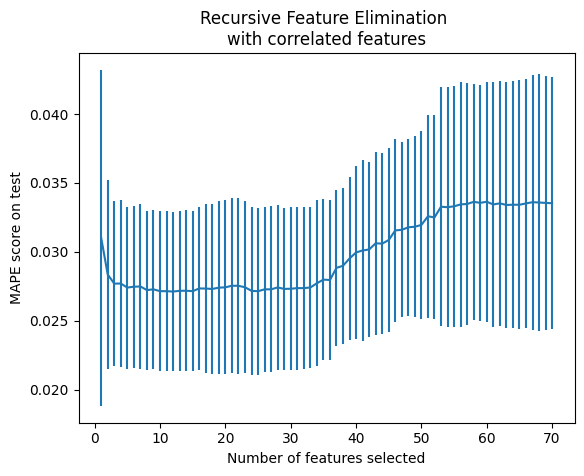

In [59]:
# visualization of MAPE score according to the number of features, on train set
n_scores = len(rfecv_lr.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("MAPE score on test")
plt.errorbar(
    range(1, n_scores + 1), # 1 is min features to select
    abs(rfecv_lr.cv_results_["mean_test_score"]),
    yerr=abs(rfecv_lr.cv_results_["std_test_score"]),
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

After a decrease of the mape with a few features, the score changes little from a few features to around 30 features.
After that, mean MAPE is increasing, and the MAPE standard deviation too.

We can also see that MAPE standard deviation is significant.

In [60]:
# let's have a look at the mean MAPE score from 5 to 35 features
rfecv_lr.cv_results_["mean_test_score"][:35]*100

array([-3.10047036, -2.83474306, -2.76876835, -2.76939195, -2.73992802,
       -2.7464051 , -2.74804295, -2.72178454, -2.72731581, -2.71396539,
       -2.71385996, -2.71112092, -2.71636289, -2.71703834, -2.71392226,
       -2.73382617, -2.73281023, -2.73003944, -2.73943417, -2.74178764,
       -2.75330365, -2.75282958, -2.74237312, -2.71660132, -2.7135799 ,
       -2.72729192, -2.72717123, -2.74105456, -2.7303495 , -2.73150355,
       -2.7359381 , -2.73613886, -2.7404972 , -2.77107174, -2.797718  ])

The best result is at the begining with a score for 12 features (2.711%) but score with 25 features is very closed (2,713%)
The variation is very light between 5 and 25 features with an increase by 0.002%.

In [61]:
# let's have a look at the std MAPE score from 5 to 35 features
rfecv_lr.cv_results_["std_test_score"][:35]*100

array([1.21960857, 0.68342742, 0.60041934, 0.6031068 , 0.58775062,
       0.58864128, 0.59663755, 0.57744327, 0.57679404, 0.58192219,
       0.58168106, 0.57715409, 0.581131  , 0.58385976, 0.57839478,
       0.5939247 , 0.61498171, 0.62003035, 0.6264614 , 0.63037763,
       0.63608817, 0.63781314, 0.62518034, 0.6119358 , 0.60579286,
       0.59946849, 0.60342652, 0.59673648, 0.59003513, 0.5905704 ,
       0.59229994, 0.59048889, 0.58506027, 0.60168702, 0.58237672])

The std minimum is reached with 9 features nevertheless in this case too the variation from 9 to 25 features is not so significant.
With 25 features, the std is 0,023% higher that is acceptable.

We think that it could be interesting to keep a significant number of features in order to be able to pick up weak signals and detct for example a trend change.
That's why we will retain a number of features of 31 for this model

In [62]:
# train and firt the model again with the number of features selected
rfe_lr = RFE(estimator=LinearRegression(), step=1, n_features_to_select=25)
rfe_lr.fit(X_train_scaler, Y_train)

RFE(estimator=LinearRegression(), n_features_to_select=25)

In [63]:
# make predictions
y_pred_train_rfe_lr = rfe_lr.predict(X_train_scaler)
y_pred_val_rfe_lr = rfe_lr.predict(X_val_scaler)

In [64]:
# Performance on both train and validation set
print("R2 score on train set : ", rfe_lr.score(X_train_scaler, Y_train).round(4))
print("R2 score on val set : ", rfe_lr.score(X_val_scaler, Y_val).round(4))
print("MAPE percent on train set : ", round(mean_absolute_percentage_error(Y_train, y_pred_train_rfe_lr)*100, ndigits=2))
print("MAPE percent on val set : ", round(mean_absolute_percentage_error(Y_val, y_pred_val_rfe_lr)*100, ndigits=2))

# we have a light increase of performance on val set, both on MAPE and R2 score.

R2 score on train set :  0.9963
R2 score on val set :  0.9496
MAPE percent on train set :  2.62
MAPE percent on val set :  1.83


In [65]:
# save the model
path_models_elasticnet = "model_rfe_lr.joblib"
joblib.dump(rfe_lr, path_models_elasticnet)

['model_rfe_lr.joblib']

In [66]:
# add model and scores to our summary table of performance
rfe_lr_results = pd.DataFrame({"R2_val_score" : rfe_lr.score(X_val_scaler, Y_val).round(4),
                                  "MAPE_val_score" : round(mean_absolute_percentage_error(Y_val, y_pred_val_rfe_lr)*100, ndigits=2),
                                 "R2_train_score" : rfe_lr.score(X_train_scaler, Y_train).round(4),
                                  "MAPE_train_score" : round(mean_absolute_percentage_error(Y_train, y_pred_train_rfe_lr)*100, ndigits=2)},
                                 index=["RFE_Linear_regression"])

models_comparison = pd.concat([models_comparison,rfe_lr_results])
models_comparison

,R2_val_score,MAPE_val_score,R2_train_score,MAPE_train_score
Linear_regression,0.9441,2.04,0.9964,2.84
RFE_Linear_regression,0.9496,1.83,0.9963,2.62


### PART III - Optimisation Linear regression with Elastic Net

We will try to optimize the linear regression using ElasticNet which allows us to combine Lasso and Ridge regularisation.
It is true that in our case, taking account the large number of features, Lasso should be the best tool to use.
Indeed, it will help us to make feature selection.

#### A. Train the model and check performances

In [67]:
# we first select a range of value for the two main hyperparameters
l1ratio_param = [.1, .3, .5, .7, .8, .9, 1]
alpha_param = [.0001, .001, .01, .1, 1, 1.2, 2, 5]

# as we are working with time series, we can used gridsearchcv for example
# so we will used a simple way of testing our model with all the parameter combinations.
# it is nsimple but does the job

# create empry list to add further values obtained
score_train = []
score_test = []
alpha_value = []
l1ratio_value = []
mape_train = []
mape_val = []

# two loops in order to iterate through hyperparamter values
for l1ratio in l1ratio_param :
    for alpha in alpha_param :
        # we adjusted tol in order to avoid a problem of convergence
        # selection ??
        model_elasticnet = ElasticNet(l1_ratio=l1ratio, alpha=alpha, random_state=0, max_iter=10000, selection="cyclic", tol=1e-2)
        model_elasticnet.fit(X_train_scaler, Y_train)
        y_train_pred = model_elasticnet.predict(X_train_scaler)
        y_val_pred = model_elasticnet.predict(X_val_scaler)
        score_train.append(model_elasticnet.score(X_train_scaler, Y_train).round(4))
        score_test.append(model_elasticnet.score(X_val_scaler, Y_val).round(4))
        mape_train.append(mean_absolute_percentage_error(Y_train, y_train_pred))
        mape_val.append(mean_absolute_percentage_error(Y_val, y_val_pred))
        alpha_value.append(alpha)
        l1ratio_value.append(l1ratio)

In [68]:
# we create a daframe to overview the best results, with the hyperparameters used
# we choose to focus on MAPE ratio, on val set.
elasticnet_results = pd.DataFrame(data = [alpha_value, l1ratio_value, score_train, score_test, mape_train, mape_val], index=["alpha value","l1 ratio","score on train set","score on val set","mape on train","mape on val"]).T
elasticnet_results.sort_values(ascending = True, by="mape on val").head(10)

,alpha value,l1 ratio,score on train set,score on val set,mape on train,mape on val
27,0.10,0.7,0.9961,0.9451,0.029068,0.019501
35,0.10,0.8,0.9961,0.9452,0.029211,0.019730
43,0.10,0.9,0.9960,0.9398,0.031560,0.020942
36,1.00,0.8,0.9957,0.9414,0.031784,0.021629
46,2.00,0.9,0.9957,0.9412,0.031728,0.021730
45,1.20,0.9,0.9958,0.9311,0.031642,0.024342
55,5.00,1.0,0.9939,0.9182,0.039332,0.024999
18,0.01,0.5,0.9940,0.9186,0.039483,0.024999
26,0.01,0.7,0.9939,0.9185,0.039554,0.025035
54,2.00,1.0,0.9939,0.9183,0.039516,0.025045


In [69]:
# fit again with best parameters
best_model_elasticnet = ElasticNet(l1_ratio=0.7, alpha=.1, random_state=0, max_iter=10000, selection="cyclic", tol=1e-2 )
best_model_elasticnet.fit(X_train_scaler, Y_train)

ElasticNet(alpha=0.1, l1_ratio=0.7, max_iter=10000, random_state=0, tol=0.01)

In [70]:
# we calculate prediction values on train and val set
train_predict_elasticnet = best_model_elasticnet.predict(X_train_scaler)
val_predict_elasticnet = best_model_elasticnet.predict(X_val_scaler)

In [71]:
# we check the performance of this model
print("Score on train set : ", best_model_elasticnet.score(X_train_scaler,Y_train).round(4))
print("Score on val set : ", best_model_elasticnet.score(X_val_scaler,Y_val).round(4))
print("MAPE percent on train set : ", round(mean_absolute_percentage_error(Y_train, train_predict_elasticnet)*100, ndigits=2))
print("MAPE percent on val set : ", round(mean_absolute_percentage_error(Y_val, val_predict_elasticnet)*100, ndigits=2))

Score on train set :  0.9961
Score on val set :  0.9451
MAPE percent on train set :  2.91
MAPE percent on val set :  1.95


In [72]:
# save the model
path_models_elasticnet = "model_elasticnet.joblib"
joblib.dump(best_model_elasticnet, path_models_elasticnet)

['model_elasticnet.joblib']

In [73]:
# add model and scores to our summary table of performance
elasticnet_results = pd.DataFrame({"R2_val_score" : best_model_elasticnet.score(X_val_scaler, Y_val).round(4),
                                  "MAPE_val_score" : round(mean_absolute_percentage_error(Y_val, val_predict_elasticnet)*100, ndigits=2),
                                 "R2_train_score" : best_model_elasticnet.score(X_train_scaler, Y_train).round(4),
                                  "MAPE_train_score" : round(mean_absolute_percentage_error(Y_train, train_predict_elasticnet)*100, ndigits=2)},
                                 index=["Elasticnet"])

models_comparison = pd.concat([models_comparison,elasticnet_results])
models_comparison

,R2_val_score,MAPE_val_score,R2_train_score,MAPE_train_score
Linear_regression,0.9441,2.04,0.9964,2.84
RFE_Linear_regression,0.9496,1.83,0.9963,2.62
Elasticnet,0.9451,1.95,0.9961,2.91


### PART IV - XGBoost

At least, we tried and XGBoost regressor.

#### A. Train a first model

In [74]:
# create the model with specific parameters :
# booster : specify the type of boosting model that will be trained. We choose gblinear which is in line with our problem. We can use also dart in order to avoid overfitting
# objective : defines the learning task and the corresponding objective function to be optimized during the training. We choose a regression task of course !
model_xgb = XGBRegressor(booster="gblinear", random_state=0, learning_rate=.4, n_estimators=300, objective="reg:squarederror")
model_xgb.fit(X_train_scaler, Y_train)

XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [75]:
# make predictions on val and train set
val_predict_xgb = model_xgb.predict(X_val_scaler)
train_predict_xgb = model_xgb.predict(X_train_scaler)

In [76]:
#check performance
print("R2 Score on train set : ",model_xgb.score(X_train_scaler, Y_train).round(4))
print("R2 Score on val set : ",model_xgb.score(X_val_scaler, Y_val).round(4))
print("MAPE Score on train set : ",mean_absolute_percentage_error(Y_train, train_predict_xgb).round(4)*100)
print("MAPE Score on val set : ",mean_absolute_percentage_error(Y_val, val_predict_xgb).round(4)*100)

R2 Score on train set :  0.9957
R2 Score on val set :  0.9324
MAPE Score on train set :  3.5700000000000003
MAPE Score on val set :  2.34


At a first look, our result are not very good compare to the precedent models.

In [77]:
# add model and scores to our summary table of performance
xgb_results = pd.DataFrame({"R2_val_score" : model_xgb.score(X_val_scaler, Y_val).round(4),
                                  "MAPE_val_score" : round(mean_absolute_percentage_error(Y_val, val_predict_xgb)*100, ndigits=2),
                                 "R2_train_score" : model_xgb.score(X_train_scaler, Y_train).round(4),
                                  "MAPE_train_score" : round(mean_absolute_percentage_error(Y_train, train_predict_xgb)*100, ndigits=2)},
                                 index=["XGBoost"])

models_comparison = pd.concat([models_comparison,xgb_results])
models_comparison

,R2_val_score,MAPE_val_score,R2_train_score,MAPE_train_score
Linear_regression,0.9441,2.04,0.9964,2.84
RFE_Linear_regression,0.9496,1.83,0.9963,2.62
Elasticnet,0.9451,1.95,0.9961,2.91
XGBoost,0.9324,2.34,0.9957,3.57


#### B. Select hyperparameters

In [78]:
# we first select a range of value for the two main hyperparameters
learning_rate_param = [.01, .05, .07, .1, .5, .6]
n_estimator_param = [10, 50, 100, 150, 200, 225, 300, 350]

# as we are working with time series, we can used gridsearchcv for example
# so we will used a simple way of testing our model with all the parameter combinations.
# it is nsimple but does the job

# create empry list to add further values obtained
score_train = []
score_val = []
learning_rate_value = []
n_estimator_value = []
mape_train_xgb = []
mape_val_xgb = []

for learning_rate in learning_rate_param :
    for n_estimator in n_estimator_param :
        model_xgb = XGBRegressor(random_state=0, learning_rate=learning_rate, n_estimators=n_estimator, objective="reg:squarederror", booster="gblinear")
        model_xgb.fit(X_train_scaler, Y_train)
        y_xgb_val_predict = model_xgb.predict(X_val_scaler)
        y_xgb_train_predict = model_xgb.predict(X_train_scaler)
        score_train.append(model_xgb.score(X_train_scaler, Y_train))
        score_val.append(model_xgb.score(X_val_scaler, Y_val))
        mape_train_xgb.append(mean_absolute_percentage_error(Y_train, y_xgb_train_predict).round(4))
        mape_val_xgb.append(mean_absolute_percentage_error(Y_val, y_xgb_val_predict).round(4))
        learning_rate_value.append(learning_rate)
        n_estimator_value.append(n_estimator)

In [79]:
# create a dataframe to overview peformance and hyperparameter values used for
xgb_results = pd.DataFrame(data = [learning_rate_value, n_estimator_value, score_train, score_val, mape_train_xgb, mape_val_xgb],
                           index=["learning rate","n estimators","score on train set","score on val set","mape on train","mape on val"]).T
xgb_results.sort_values(ascending = True, by="mape on val").head(10)

,learning rate,n estimators,score on train set,score on val set,mape on train,mape on val
14,0.05,300.0,0.996033,0.941382,0.0307,0.0205
11,0.05,150.0,0.995905,0.943100,0.0314,0.0206
28,0.10,200.0,0.996026,0.941010,0.0309,0.0207
19,0.07,150.0,0.995917,0.937983,0.0318,0.0214
22,0.07,300.0,0.996046,0.938141,0.0310,0.0214
12,0.05,200.0,0.995941,0.938229,0.0314,0.0214
13,0.05,225.0,0.995959,0.936707,0.0314,0.0218
18,0.07,100.0,0.995830,0.939506,0.0322,0.0220
23,0.07,350.0,0.996063,0.936070,0.0308,0.0222
29,0.10,225.0,0.995948,0.932044,0.0326,0.0228


In [80]:
# use the best hyperparameters to fit our xgb model
best_model_xgb = XGBRegressor(random_state=0, learning_rate=0.05, n_estimators=150, objective="reg:squarederror", booster="gblinear")
best_model_xgb.fit(X_train_scaler, Y_train)

# make predictions
train_predict_xgb = best_model_xgb.predict(X_train_scaler)
y_val_predict_xgb = best_model_xgb.predict(X_val_scaler)

# check performance
print("Score on train set : ",best_model_xgb.score(X_train_scaler, Y_train).round(4))
print("Score on val set : ",best_model_xgb.score(X_val_scaler, Y_val).round(4))
print("MAPE on train set : ", round(mean_absolute_percentage_error(Y_train, train_predict_xgb),4)*100)
print("MAPE on val set : ",round(mean_absolute_percentage_error(Y_val, val_predict_xgb),4)*100)


Score on train set :  0.9959
Score on val set :  0.9424
MAPE on train set :  3.15
MAPE on val set :  2.34


We can see that there is a certain volatility on the result with xgb.

In [81]:
# save the model
path_model_xgb = "best_model_xgb.joblib"
joblib.dump(best_model_xgb, path_model_xgb)

['best_model_xgb.joblib']

#### C. Select best features

In [82]:
# Instantiate RFECV with a XGBoost model
rfecv_xgb = RFECV(estimator=best_model_xgb, step=1, scoring="neg_mean_absolute_percentage_error", cv=10)
# Fit the data
rfecv_xgb.fit(X_train_scaler, Y_train)          

RFECV(cv=10,
      estimator=XGBRegressor(base_score=None, booster='gblinear',
                             callbacks=None, colsample_bylevel=None,
                             colsample_bynode=None, colsample_bytree=None,
                             device=None, early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, gamma=None, grow_policy=None,
                             importance_type=None, interaction_constraints=None,
                             learning_rate=0.05, max_bin=None,
                             max_cat_threshold=None, max_cat_to_onehot=None,
                             max_delta_step=None, max_depth=None,
                             max_leaves=None, min_child_weight=None,
                             missing=nan, monotone_constraints=None,
                             multi_strategy=None, n_estimators=150, n_jobs=None,
                             num_parallel_tree=None, random_state=0, ...),
      scoring='neg_mean_absolute_percentage_error')

In [83]:
# get the number of features selected
print("The number of features selected is : ",len(rfecv_xgb.get_feature_names_out()))

The number of features selected is :  23


In [84]:
print("Feature ranking: ", rfecv_xgb.ranking_)

Feature ranking:  [ 1  1  1  1 43 18 39 16 31 37  9 17 38  1  1  1  7  6  5 10  4  1  1  1
  1 12 27  1  1  1  1  3 45  8 48 21 13 20 40 29 11 14  1  1  2  1 44  1
 28 32 42 33 36  1 15 46 23  1  1  1 19 35 41 47 26 30 34 22 25 24]


In [85]:
# make the list of all the features, and those selected
mask = rfecv_xgb.get_support()
features = np.array(X_train.columns)
best_features = features[mask]

print("All features: ", X_train.shape[1])
print(features)
print()
print("Selected best: ", best_features.shape[0])
print(features[mask])  

All features:  70
['Open' 'High' 'Low' 'Close' 'Volume' 'Williams_%R14' 'ROC_14' 'rsi_7'
 'rsi_14' 'rsi_28' 'MACD_Line' 'Signal_Line' 'MACD_Histogram'
 'midlle_band' 'upper_band20' 'lower_band20' 'Tenkan_sen' 'Kijun_sen'
 'Senkou_Span_A' 'Senkou_Span_B' 'Chikou_Span' 'ema_3' 'ema_8' 'ema_15'
 'ema_50' 'ema_100' 'ADX_14' 'Donchian_Upper_10' 'Donchian_Lower_10'
 'Donchian_Upper_20' 'Donchian_Lower_20' 'ALMA_10' 'TSI_13_25'
 'Z_Score_20' 'LogReturn_10' 'LogReturn_20' 'Positive_VI_7'
 'Negative_VI_7' 'Aroon_Up_16' 'Aroon_Down_16' 'Bull_Power_14'
 'Bear_Power_14' 'Upper_Band_20' 'Lower_Band_20' 'Middle_Band_20'
 'Short_Run_14' 'Bias_26' 'TTM_Trend_5_20' 'Percent_Return_10'
 'Percent_Return_20' 'kurtosis_5' 'kurtosis_10' 'kurtosis_20' 'ERI_13'
 'atr_14' 'TR' 'ATR' 'Middle Band' 'Upper Band' 'Lower Band'
 'Chaikin_Volatility_10' 'Stdev_5' 'Stdev_10' 'Stdev_20' 'VIX_21' 'OBV_10'
 'CMF_5' 'VPT_7' 'A/D Line_3' 'EOM_14']

Selected best:  23
['Open' 'High' 'Low' 'Close' 'midlle_band' 'upper_band20

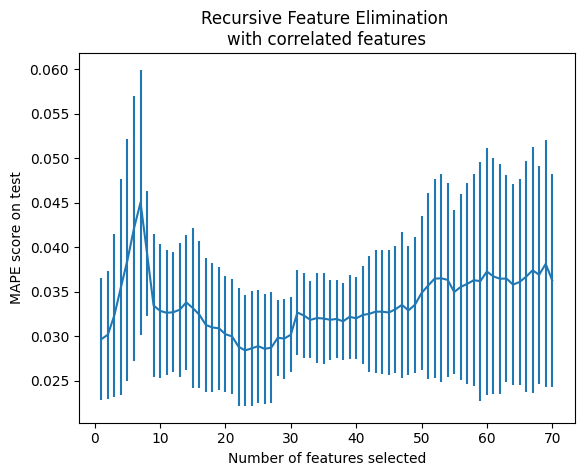

In [86]:
# visualization of MAPE score according to the number of features, on train set
n_scores = len(rfecv_xgb.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("MAPE score on test")
plt.errorbar(
    range(1, n_scores + 1), # 1 is min features to select
    abs(rfecv_xgb.cv_results_["mean_test_score"]),
    yerr=abs(rfecv_xgb.cv_results_["std_test_score"]),
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

According to RFE process, selecting only 23 features is the best option.

In [87]:
# let's have a look at the mean MAPE score from 1 to 30 features
abs(rfecv_xgb.cv_results_["mean_test_score"][:30]*100)

array([2.96608157, 3.01687852, 3.23638066, 3.55096615, 3.85642465,
       4.21283486, 4.50385944, 3.93083574, 3.34491126, 3.28426991,
       3.26332302, 3.26907527, 3.29805   , 3.38002179, 3.31679731,
       3.24162072, 3.12595437, 3.09806305, 3.08855702, 3.02157248,
       2.9979519 , 2.88197271, 2.83956807, 2.86330668, 2.8878197 ,
       2.85753506, 2.87097112, 2.982188  , 2.97306168, 3.01691561])

As expected, with 23 features the score is 2.84%. With 26 six features, the score will increase only by 0.016% which is not significant.

In [88]:
# let's have a look at the std MAPE score from 5 to 35 features
rfecv_xgb.cv_results_["std_test_score"][:30]*100

array([0.68591264, 0.71988933, 0.91581937, 1.21295069, 1.35917924,
       1.49148776, 1.49090181, 0.69866803, 0.80393838, 0.75695859,
       0.70247727, 0.67339738, 0.75198158, 0.76222638, 0.8989693 ,
       0.82887163, 0.74994566, 0.72319443, 0.69265885, 0.65198556,
       0.64422441, 0.66521646, 0.62148864, 0.64770533, 0.63694219,
       0.61739481, 0.62696903, 0.42727111, 0.44934309, 0.42000095])

Following the previous comments, std with 26 features at 0.62 which is the lowest std.

In [89]:
# train and fit the model again with the number of features selected
rfe_xgb = RFE(estimator=best_model_xgb, step=1, n_features_to_select=26)
rfe_xgb.fit(X_train_scaler, Y_train)

RFE(estimator=XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, device=None,
                           early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, feature_types=None, gamma=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=0.05,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, multi_strategy=None,
                           n_estimators=150, n_jobs=None,
                           num_parallel_tree=None, random_state=0, ...),
    n_features_to_select=26)

In [90]:
# make predictions
y_pred_train_rfe_xgb = rfe_xgb.predict(X_train_scaler)
y_pred_val_rfe_xgb = rfe_xgb.predict(X_val_scaler)

In [91]:
# Performance on both train and validation set
print("R2 score on train set : ", rfe_xgb.score(X_train_scaler, Y_train).round(4))
print("R2 score on val set : ", rfe_xgb.score(X_val_scaler, Y_val).round(4))
print("MAPE percent on train set : ", round(mean_absolute_percentage_error(Y_train, y_pred_train_rfe_xgb)*100, ndigits=2))
print("MAPE percent on val set : ", round(mean_absolute_percentage_error(Y_val, y_pred_val_rfe_xgb)*100, ndigits=3))

# we have a light increase of performance on val set, both on MAPE and R2 score.

R2 score on train set :  0.9959
R2 score on val set :  0.944
MAPE percent on train set :  2.79
MAPE percent on val set :  1.958


In [92]:
# save the model
path_models_elasticnet = "model_rfe_xgb.joblib"
joblib.dump(rfe_xgb, path_models_elasticnet)

['model_rfe_xgb.joblib']

In [93]:
# add model and scores to our summary table of performance
rfe_xgb_results = pd.DataFrame({"R2_val_score" : rfe_xgb.score(X_val_scaler, Y_val).round(4),
                                  "MAPE_val_score" : round(mean_absolute_percentage_error(Y_val, y_pred_val_rfe_xgb)*100, ndigits=2),
                                 "R2_train_score" : rfe_xgb.score(X_train_scaler, Y_train).round(4),
                                  "MAPE_train_score" : round(mean_absolute_percentage_error(Y_train, y_pred_train_rfe_xgb)*100, ndigits=2)},
                                 index=["RFE_XGBoost"])

models_comparison = pd.concat([models_comparison,rfe_xgb_results])
models_comparison

,R2_val_score,MAPE_val_score,R2_train_score,MAPE_train_score
Linear_regression,0.9441,2.04,0.9964,2.84
RFE_Linear_regression,0.9496,1.83,0.9963,2.62
Elasticnet,0.9451,1.95,0.9961,2.91
XGBoost,0.9324,2.34,0.9957,3.57
RFE_XGBoost,0.9440,1.96,0.9959,2.79


### PART V - Test models

To resume, we hace now different models to test :
1) Linear regression, simple version
2) Linear regression with features selection
3) Elastic net optimized
4) XGBoost, simple version,
5) XGBoost with features selection

We will test only models 2, 3 and 5

#### A. Test models on test set

##### A.1 Performance

In [94]:
def performance_model_test(model) :
    test_predict=model.predict(X_test_scaler)
    r2_score_test = model.score(X_test_scaler, Y_test).round(3)
    mape_score_test = round(mean_absolute_percentage_error(Y_test, test_predict)*100, ndigits=2)
    return r2_score_test, mape_score_test, test_predict

In [95]:
r2_rfe_lr, mape_rfe_lr, test_predict_rfe_lr = performance_model_test(rfe_lr)
r2_rfe_xgb, mape_rfe_xgb, test_predict_rfe_xgb = performance_model_test(rfe_xgb)
r2_rfe_elasticnet, mape_rfe_elasticnet, test_predict_elasticnet = performance_model_test(best_model_elasticnet)

In [96]:
# dataframe with perf on test set
best_results = pd.DataFrame({"name" : ["Linear regression with RFE", "XGBoost with RFE","Elasticnet with fine tuning"],
                             "R2 score" : [r2_rfe_lr, r2_rfe_xgb, r2_rfe_elasticnet],
                             "MAPE" : [mape_rfe_lr, mape_rfe_xgb, mape_rfe_elasticnet]
                             })

In [97]:
best_results

,name,R2 score,MAPE
0,Linear regression with RFE,0.969,1.33
1,XGBoost with RFE,0.963,1.50
2,Elasticnet with fine tuning,0.967,1.44


##### A.2 Visualisation

In [98]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index,
                         y=Y_test,
                         mode="lines",
                         name="Original Close price"))
fig.update_layout(title_text='Comparison between original Close price vs predicted close price', font_size=15, font_color='black')
fig.add_trace(go.Scatter(x=X_test.index,
                         y=test_predict_rfe_xgb,
                         mode="lines",
                         name="Prediction with XGB"))
fig.add_trace(go.Scatter(x=X_test.index,
                         y=test_predict_elasticnet,
                         mode="lines",
                         name="Prediction with Elasticnet"))
fig.add_trace(go.Scatter(x=X_test.index,
                         y=test_predict_rfe_lr,
                         mode="lines",
                         name="Prediction with Linear regression"))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

#### B. Predict on new data

In [99]:
# predict the price for tomorrow
def price_prediction(model) :
    """
    function allows to make a prediction for the next day
    raw data are collected from yfinance over a period of 200 days from now, on a daily basis
    function expands the database with all the features we need
    args :
    model = model used to make prediciton
    Returns:
        price of bitcoin for tomorrow :
    """
    btc_ticker = yf.Ticker("BTC-EUR")
    btc_actual = btc_ticker.history(period="200d", actions=False) # get data from yfinance
    btc_actual = btc_actual.tz_localize(None) # normalize timezone
    btc_actual = calculate_all_indicators_optimised(btc_actual) # calculate indicators and add columns to the dataset
    btc_actual = btc_actual.sort_index(ascending=False) # sort by decreasing chronological order
    input_data = btc_actual.iloc[0,:] # take the first row which is the last date available
    input_data = input_data.fillna(0) # fillna per zero value
    input_data = input_data.array
    input_data = input_data.reshape(1,-1)
    input_data = scaler.transform(input_data) # tranform data with scaler 
    futur_price = model.predict(input_data) # predict 
    return futur_price

In [100]:
print("The prediction will be for tomorrow : {} euros".format(int(price_prediction(rfe_lr)[0])))

The prediction will be for tomorrow : 36786 euros


In [101]:
print("The prediction will be for tomorrow : {} euros".format(int(price_prediction(rfe_xgb)[0].round(1))))

The prediction will be for tomorrow : 37083 euros


In [102]:
print("The prediction will be for tomorrow : {} euros".format(int(price_prediction(best_model_elasticnet)[0])))

The prediction will be for tomorrow : 36872 euros


### PART VI - Create model for different horizon of time